In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

KeyboardInterrupt: 

In [ ]:
extra_bad = None
#extra_bad = np.isnan(np.zeros((64, 64)).at[35,60].set(np.nan))

#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)


In [ ]:
wid = 64
oversample = 4

nwavels = 3#10#6
npoly=1#3#2

n_zernikes = 12

optics = NICMOSOptics(1024, wid, oversample, n_zernikes = n_zernikes)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"

# brown dwarf

files = [
    'n8yj53vfq_cal.fits'

]


# lhs 1846
ddir = "../data/MAST_2025-03-02T22_29_29.259Z/HST/"

files = ["n8ku01ffq_cal.fits", "n8ku01fgq_cal.fits"][:1]

ddir = "../data/MAST_2024-09-08T07_59_18.213Z/HST/"

files = [
    # F095N
    "n43ca5fjq_cal.fits",
    "n43ca5fkq_cal.fits",
    "n43ca5flq_cal.fits",
    "n43ca5fmq_cal.fits",
    #F190N
    "n43ca5feq_cal.fits",
    "n43ca5ffq_cal.fits",
    "n43ca5fgq_cal.fits",
    "n43ca5fhq_cal.fits",
    #F187N
    #"n43c03dnq_cal.fits",
    #"n43c03doq_cal.fits",
    #"n43c03dpq_cal.fits",
    #"n43c03drq_cal.fits",
    #F108N
    #"n43c03dsq_cal.fits",
    #"n43c03duq_cal.fits",
    ##"n43c03dvq_cal.fits",
    ##"n43c03dwq_cal.fits",
][-1:]

# hyades
"""
ddir = "../data/MAST_2024-09-26T22_53_13.719Z/HST/"

files = [
    "n8ry37p8q_cal.fits",
    "n8ry37p9q_cal.fits",

    #"n8ry13mqq_cal.fits",
    #"n8ry13mrq_cal.fits"
][:-1]
"""

"""
ddir = '../data/MAST_2025-03-06T11_35_52.340Z/HST/'

files = [
    #F110M
    'n4be02npq_cal.fits',
    'n4be02nsq_cal.fits',
    'n4be02nvq_cal.fits',
    'n4be02nyq_cal.fits',

    #F145M
    'n4be02nqq_cal.fits',
    'n4be02ntq_cal.fits',
    'n4be02nwq_cal.fits',
    'n4be02o0q_cal.fits',
]#[:1]#[-2:-1]
"""
#extra_bad = np.isnan(np.zeros((wid,wid))).at[wid//2-3:wid//2+3,:].set(np.nan)

exposures_single = [exposure_from_file(ddir + file, BreathingSinglePointFit(CombinedBinnedSpectrum, nwavels, 5), crop=wid, extra_bad=extra_bad) for file in files]

#exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid, extra_bad=extra_bad) for file in files]

/var/folders/hv/659ls99s2sjd7m3dfr17k8cm0000gn/T/ipykernel_77412/76572953.py:85: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  exposures_single = [exposure_from_file(ddir + file, BreathingSinglePointFit(CombinedBinnedSpectrum, nwavels, 5), crop=wid, extra_bad=extra_bad) for file in files]


In [ ]:
for e in exposures_single:
    print(e.mjd)#*86400)
    print(e.target)
    print(e.filter)

50934.93448622
SAO179809-PSF
F190N


In [ ]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},

    #"rot": 0.,

    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,

    "softening": 2.,#0.1,
    "bias": {},
    "jitter": {},
    "breathing": {},
    #"displacement": 1.#1e5#{}
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels/0.3)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.asarray([-18.26955948, -18.512698  ,  12.14269164,  22.50688544,
        29.51561361,  10.87845929,  13.14157233, -11.42129773,
       -11.54438252,   5.96948131,  15.89102707,   1.78613375])#np.zeros(n_zernikes)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([8., 8.])
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. + 90. 
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])
    #params["displacement"][exp.fit.get_key(exp, "displacement")] = 1e6

    params["breathing"][exp.fit.get_key(exp, "breathing")] = -1.

    params["bias"][exp.fit.get_key(exp, "bias")] = 0.
    params["jitter"][exp.fit.get_key(exp, "jitter")] = 7/43*oversample


model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
#model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [ ]:
exp.fit.get_key(exp, "primary_distortion")

'global'

In [ ]:
optics

NICMOSOptics(
  wf_npixels=1024,
  diameter=2.4,
  layers={
    'CompoundAperture':
    CompoundAperture(
      normalise=True,
      transformation=CoordTransform(
        translation=None, rotation=f32[], compression=None, shear=None
      ),
      apertures={
        'main_aperture':
        HSTMainAperture(
          normalise=True,
          transformation=CoordTransform(
            translation=None, rotation=f32[], compression=None, shear=None
          ),
          apertures={
            'mirror':
            CircularAperture(
              normalise=False,
              transformation=None,
              occulting=False,
              softness=2.0,
              radius=1.2
            ),
            'spider':
            Spider(
              normalise=False,
              transformation=None,
              occulting=True,
              softness=2.0,
              width=0.026399999999999996,
              angles=f32[4]
            ),
            'secondary':
            Circu

In [ ]:
#plt.imshow(exposures_single[0].fit(model_single,exposures_single[0])**0.125)

KeyboardInterrupt: 

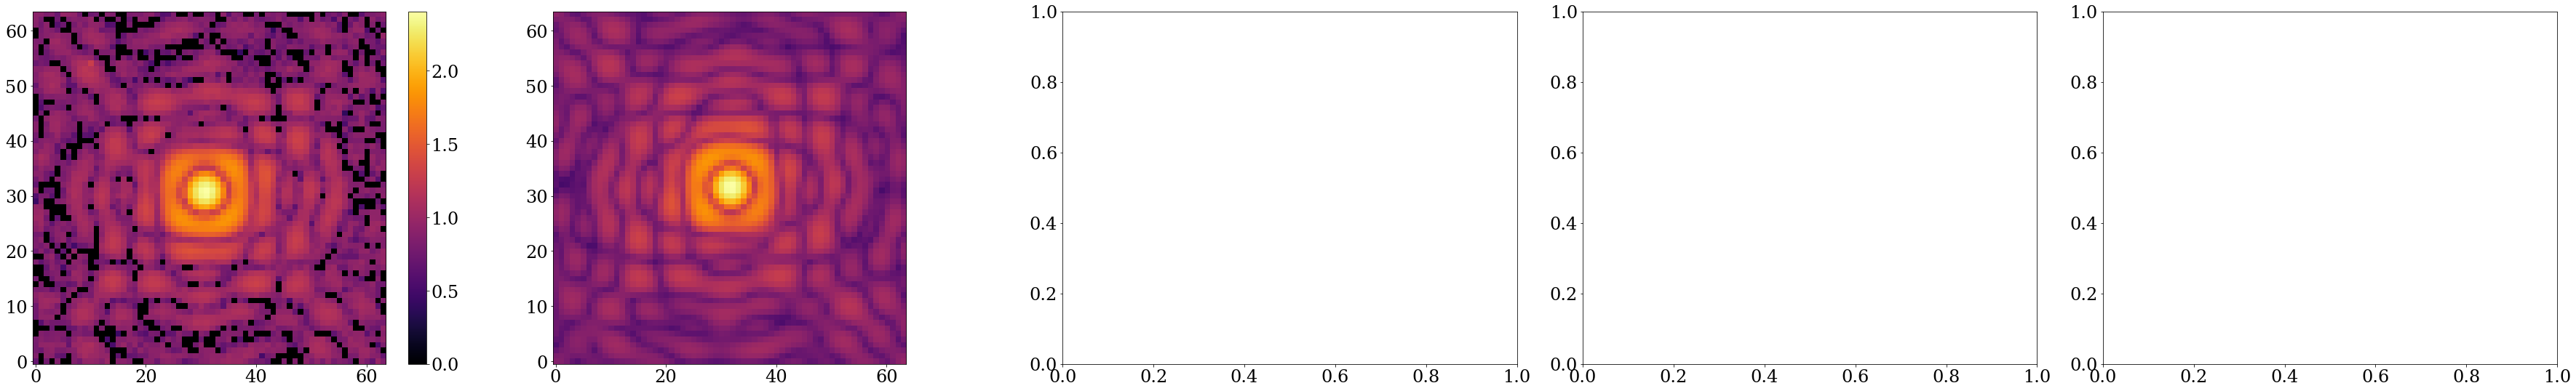

In [ ]:
plot_comparison(model_single, params, exposures_single)

In [ ]:
exposures_single[0].bad[35,60]

Array(True, dtype=bool)

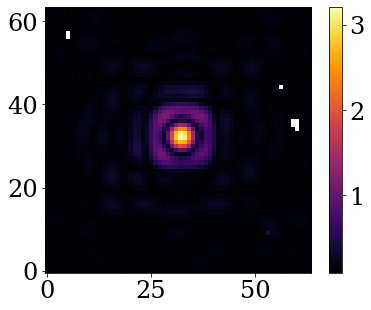

In [ ]:
plt.imshow(exposures_single[0].err)
plt.colorbar()

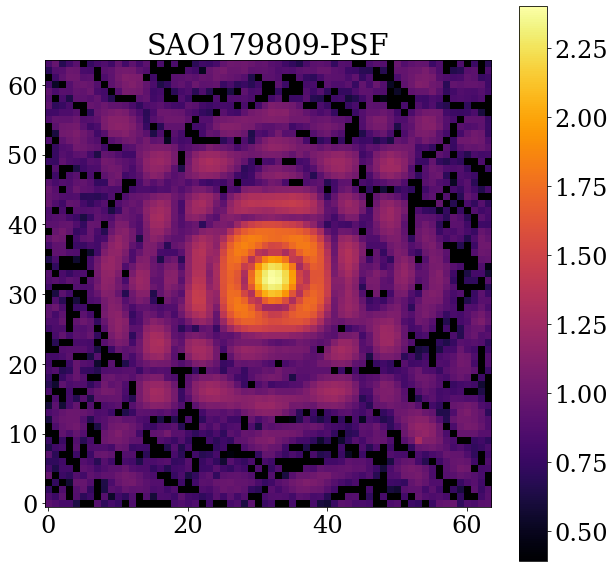

In [ ]:
cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)
plt.figure(figsize=(10,10))
plt.imshow(exposures_single[0].data**0.125, cmap=cmap)
plt.title(exposures_single[0].target)
plt.colorbar()


In [ ]:
#stop

In [ ]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

In [ ]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))

base_lbfgs = lambda vals: optax.lbfgs(vals)

optl = lambda lr, start, *schedule: base_lbfgs(scheduler(lr, start, *schedule))




def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-2

things = {
    "positions": opt(g*5, 0),
    "spectrum": opt(g*5, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*150, 20),

    "aberrations": opt(g*0.3, 50),

    #"cold_mask_rot": opt(g*10, 100),
    #"bias": opt(g*3, 20),
    #"aberrations": opt(g*0.15,300),#, (80, 2)),#, (150, g*0.2)),
    #"aberrations": opta(2, 50),
    #"aberrations": opta(2, 50),
    #"aberrations": optl(2,50),
    #"displacement": opt(g*30, 150),

    "breathing": opt(g*100, 80),

    #"cold_mask_scale": opt(g*100, 250),
    #"cold_mask_shear": opt(g*100, 250),
    #"primary_scale": opt(g*100, 300),
    #"primary_shear": opt(g*100, 300),
}


groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [ ]:
losses, models = optimise(params, model_single, exposures_single, things, 100)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

ModelParams(
  params={
    'positions': {'n43ca5fhq': f32[2]},
    'spectrum': {'SAO179809-PSF_F190N': f32[1]},
    'aberrations': {'n43ca5fhq': f32[12]},
    'cold_mask_shift': {'50935': f32[2]},
    'cold_mask_rot': {'global': -45.0},
    'cold_mask_scale': {'F190N': f32[2]},
    'cold_mask_shear': {'F190N': f32[2]},
    'primary_scale': {'F190N': f32[2]},
    'primary_rot': {'F190N': 45.0},
    'primary_shear': {'F190N': f32[2]},
    'outer_radius': 1.146,
    'secondary_radius': 0.44639999999999996,
    'spider_width': 0.0924,
    'scale': 0.0432,
    'softening': 2.0,
    'bias': {'n43ca5fhq': 0.0},
    'jitter': {'n43ca5fhq': 0.6511627906976745},
    'breathing': {'n43ca5fhq': -1.0}
  }
)
Fitting Model


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
losses[-1]

Array(7438.1367, dtype=float32)

In [ ]:
# 5.813

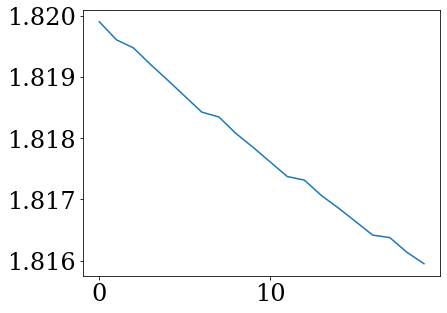

In [ ]:
plt.plot(np.asarray(losses[-20:])/(len(exposures_single)*wid**2))

5


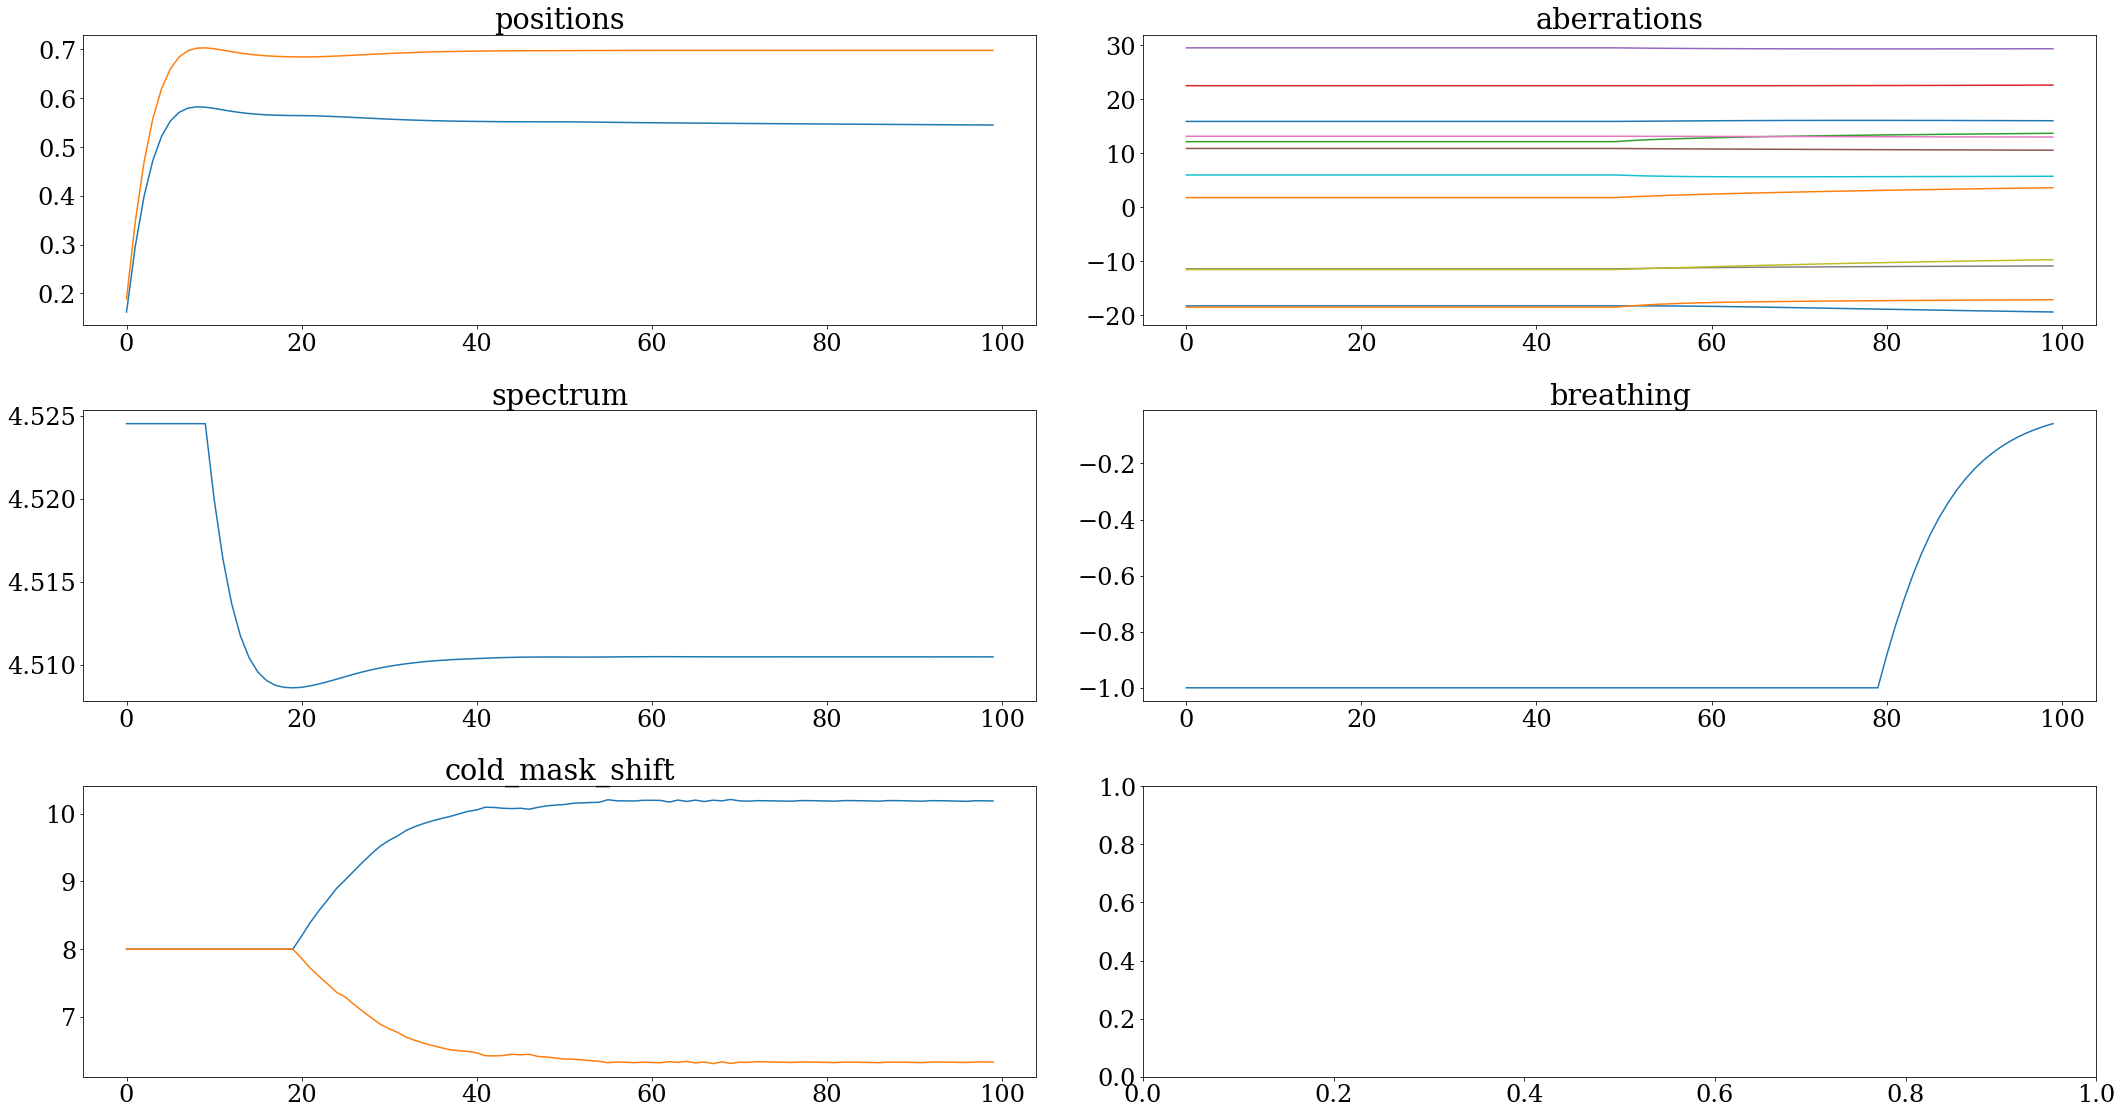

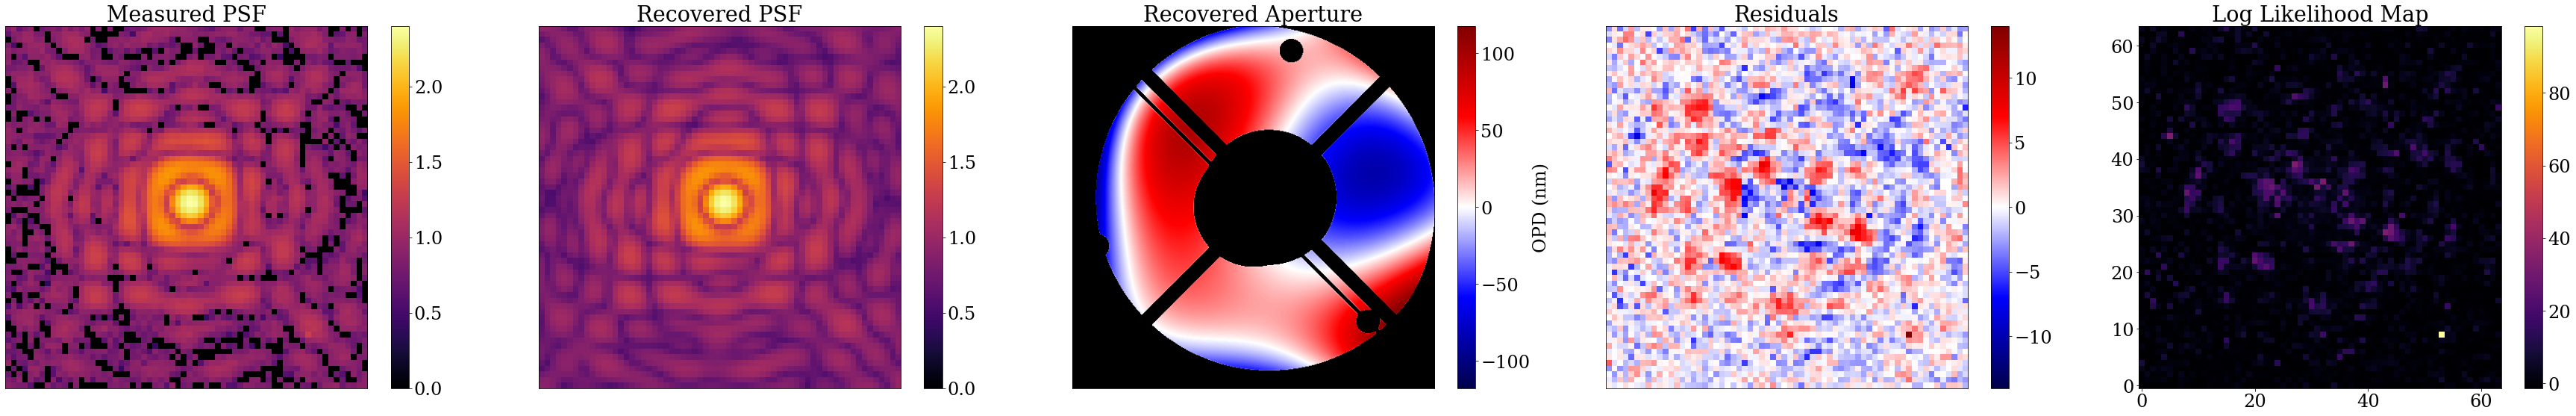

In [ ]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [ ]:
models[-1].params

{'aberrations': {'n43ca5fhq': Array([-19.406214 , -17.13516  ,  13.694094 ,  22.6175   ,  29.350538 ,
          10.558752 ,  12.998855 , -10.876425 ,  -9.714578 ,   5.7303224,
          16.01397  ,   3.6089635], dtype=float32)},
 'breathing': {'n43ca5fhq': Array(-0.05822016, dtype=float32)},
 'cold_mask_shift': {'50935': Array([10.190123,  6.330792], dtype=float32)},
 'positions': {'n43ca5fhq': Array([0.54510325, 0.6980268 ], dtype=float32)},
 'spectrum': {'SAO179809-PSF_F190N': Array([4.510466], dtype=float32)}}